> 

In [6]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [7]:
import pandas as pd

df = pd.read_parquet('../../data.parquet')
df.head()

,Airline Code,Aircraft Registration,Operator,Type Code,Mode S,Serial Number,Age(years),FROM,TO,Arrival_Delayed,...,STD_UTC_day_of_year,STD_UTC_week_of_year,STD_UTC_weekday,STD_UTC_hour_of_day,STA_UTC_time_of_day_cosine,STA_UTC_time_of_year_cosine,STA_UTC_day_of_year,STA_UTC_week_of_year,STA_UTC_weekday,STA_UTC_hour_of_day
0,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,YIN,TFU,True,...,244,35,5,3,0.021815,-0.492533,244.0,35.0,5.0,5.0
1,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,TFU,YIN,False,...,243,35,4,20,0.707107,-0.492533,244.0,35.0,5.0,3.0
2,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,URC,TFU,True,...,243,35,4,17,0.362438,-0.507430,243.0,35.0,4.0,19.0
3,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,TFU,URC,False,...,243,35,4,3,-0.642788,-0.507430,243.0,35.0,4.0,8.0
4,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,ZHA,TFU,False,...,242,35,3,23,0.854912,-0.507430,243.0,35.0,4.0,2.0


In [8]:
columns_to_drop = [col for col in df.columns if col.startswith('ATA') or col.startswith('ATD') or col == 'Arrival_Delayed']
df.drop(columns=columns_to_drop, inplace=True)

In [9]:
# all columns of first row 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
df.dtypes

Airline Code                   category
Aircraft Registration          category
Operator                       category
Type Code                      category
Mode S                         category
Serial Number                  category
Age(years)                      float32
FROM                           category
TO                             category
Departure_Status               category
STD_temp_scaled                 float64
STD_dwpt_scaled                 float64
STD_rhum_scaled                 float64
STD_prcp_scaled                 float64
STD_snow_scaled                 float64
STD_wdir_scaled                 float64
STD_wspd_scaled                 float64
STD_wpgt_scaled                 float64
STD_pres_scaled                 float64
STD_tsun_scaled                 float64
STD_coco_scaled                 float64
STA_temp_scaled                 float64
STA_dwpt_scaled                 float64
STA_rhum_scaled                 float64
STA_prcp_scaled                 float64


In [10]:
# Convert float64 to float32
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].astype('float32')

# Convert int64 to int32
int_cols = df.select_dtypes(include='int64').columns
df[int_cols] = df[int_cols].astype('int32')

In [11]:
X = df.drop(columns = ["Departure_Status"])
y = df["Departure_Status"].astype('category').cat.codes
catFeat = X.select_dtypes(include='category').columns.tolist() 
catFeat 

['Airline Code',
 'Aircraft Registration',
 'Operator',
 'Type Code',
 'Mode S',
 'Serial Number',
 'FROM',
 'TO']

In [12]:
# 60 % training, 40 % temp (to split into test and validation)  
xTrain, xTemp, yTrain , yTemp = train_test_split(X, y, test_size = 0.4, random_state = 42) 

# 20 % test, 20 % validation 
xTest, xVal, yTest, yVal = train_test_split(xTemp, yTemp, test_size = 0.5, random_state = 42) 

xTrain.shape, xTest.shape, xVal.shape

((7001872, 43), (2333957, 43), (2333958, 43))

In [13]:
dtrain = xgb.DMatrix(xTrain, label=yTrain,enable_categorical=True)
dval = xgb.DMatrix(xVal, label=yVal,enable_categorical=True)
dtest = xgb.DMatrix(xTest, label=yTest,enable_categorical=True)


### GridSearch

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm import tqdm
import time

# Re-importing the dataset for reinitialization
df = pd.read_parquet('data.parquet')

# Reinitializing:
columns_to_drop = [col for col in df.columns if col.startswith('ATA') or col.startswith('ATD') or col == 'Arrival_Delayed']
df.drop(columns=columns_to_drop, inplace=True)

# Convert float64 to float32
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].astype('float32')

# Convert int64 to int32
int_cols = df.select_dtypes(include='int64').columns
df[int_cols] = df[int_cols].astype('int32')

# Restart grid search setup
X = df.drop(columns=["Departure_Status"])
y = df["Departure_Status"].astype('category').cat.codes

#  Data splitting again
xTrain, xTemp, yTrain, yTemp = train_test_split(X, y, test_size=0.4, random_state=42)
xTest, xVal, yTest, yVal = train_test_split(xTemp, yTemp, test_size=0.5, random_state=42)

# Creating DMatrixes
dtrain = xgb.DMatrix(xTrain, label=yTrain, enable_categorical=True)
dval = xgb.DMatrix(xVal, label=yVal, enable_categorical=True)
dtest = xgb.DMatrix(xTest, label=yTest, enable_categorical=True)

params_grid = {
    'objective': ['multi:softmax'],
    'num_class': [3],
    'eval_metric': ['mlogloss'],
    'max_depth': [6, 8, 10],             
    'eta': [0.05, 0.1, 0.2],              
    'subsample': [0.6, 0.8, 1.0],         
    'colsample_bytree': [0.8, 1.0],       
    'gamma': [0, 0.1],                    
    'lambda': [3],                        
    'alpha': [0],                         
    'tree_method': ['gpu_hist'],
    'random_state': [42]
}

best_params = None
best_score = float('inf')
evals = [(dtrain, 'Train'), (dval, 'Validation')]
num_round = 300

# Initialize tqdm progress bar
param_combinations = list(ParameterGrid(params_grid))
progress_bar = tqdm(total=len(param_combinations), desc="Grid Search")

# Running the grid search now
for params in param_combinations:
    start_time = time.perf_counter()
    model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=False)
    elapsed_time = time.perf_counter() - start_time

    progress_bar.set_postfix({"best_score": model.best_score, "elapsed_time": f"{elapsed_time:.2f}s"})
    progress_bar.update(1)

    if model.best_score < best_score:
        best_score = model.best_score
        best_params = params

progress_bar.close()

best_params

Grid Search:   0%|          | 0/108 [00:51<?, ?it/s]
/root/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Grid Search:   1%|          | 1/108 [01:39<2:57:31, 99.55s/it, best_score=0.227, elapsed_time=99.54s]/root/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Grid Search:   2%|▏         | 2/108 [03:20<2:57:10, 100.29s/it, best_score=0.225, elapsed_time=100.81s]/root/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: 

{'alpha': 0,
 'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'lambda': 3,
 'max_depth': 10,
 'num_class': 3,
 'objective': 'multi:softmax',
 'random_state': 42,
 'subsample': 1.0,
 'tree_method': 'gpu_hist'}

## Training

In [14]:
params = {'alpha': 0,
 'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'lambda': 3,
 'max_depth': 10,
 'num_class': 3,
 'objective': 'multi:softmax',
 'random_state': 42,
 'subsample': 1.0,
 'tree_method': 'gpu_hist'}

evals = [(dtrain, 'Train'), (dval, 'Validation')]
num_round = 10000


# Training the model

model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=True)
model.save_model('xgboost_model.json')

c:\Users\G5\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	Train-mlogloss:0.87884	Validation-mlogloss:0.87895
[1]	Train-mlogloss:0.72773	Validation-mlogloss:0.72797
[2]	Train-mlogloss:0.61791	Validation-mlogloss:0.61831
[3]	Train-mlogloss:0.53668	Validation-mlogloss:0.53724
[4]	Train-mlogloss:0.47405	Validation-mlogloss:0.47479
[5]	Train-mlogloss:0.42486	Validation-mlogloss:0.42585
[6]	Train-mlogloss:0.38756	Validation-mlogloss:0.38878
[7]	Train-mlogloss:0.35719	Validation-mlogloss:0.35870
[8]	Train-mlogloss:0.33389	Validation-mlogloss:0.33566
[9]	Train-mlogloss:0.31536	Validation-mlogloss:0.31743
[10]	Train-mlogloss:0.30016	Validation-mlogloss:0.30252
[11]	Train-mlogloss:0.28714	Validation-mlogloss:0.28986
[12]	Train-mlogloss:0.27638	Validation-mlogloss:0.27950
[13]	Train-mlogloss:0.26770	Validation-mlogloss:0.27121
[14]	Train-mlogloss:0.26011	Validation-mlogloss:0.26404
[15]	Train-mlogloss:0.25400	Validation-mlogloss:0.25836
[16]	Train-mlogloss:0.24865	Validation-mlogloss:0.25352
[17]	Train-mlogloss:0.24414	Validation-mlogloss:0.24950
[1

c:\Users\G5\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

yValidatePred = model.predict(dval)  # No need for np.argmax()

# 7️⃣ Evaluate model performance
validationAccuracy = accuracy_score(yVal, yValidatePred)
print("Validation Accuracy:", validationAccuracy)

confusionMatrix = confusion_matrix(yVal, yValidatePred)
print("Confusion Matrix:\n", confusionMatrix)

classificationReport = classification_report(yVal, yValidatePred)
print("Classification Report:\n", classificationReport)

Validation Accuracy: 0.9214848767629923
Confusion Matrix:
 [[   8336    1832     144]
 [    184 2106991   15569]
 [    165  165357   35380]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     10312
           1       0.93      0.99      0.96   2122744
           2       0.69      0.18      0.28    200902

    accuracy                           0.92   2333958
   macro avg       0.86      0.66      0.71   2333958
weighted avg       0.91      0.92      0.90   2333958



In [16]:
yTestPred = model.predict(dtest)

# 9️⃣ Evaluate test set performance
print("\n🔹 Test Set Evaluation 🔹")
testAccuracy = accuracy_score(yTest, yTestPred)
print("Test Accuracy:", testAccuracy)

confusionMatrixTest = confusion_matrix(yTest, yTestPred)
print("Test Confusion Matrix:\n", confusionMatrixTest)

classificationReportTest = classification_report(yTest, yTestPred)
print("Test Classification Report:\n", classificationReportTest)


🔹 Test Set Evaluation 🔹
Test Accuracy: 0.9215812459269815
Test Confusion Matrix:
 [[   8390    1846     119]
 [    176 2106993   15278]
 [    152  165455   35548]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     10355
           1       0.93      0.99      0.96   2122447
           2       0.70      0.18      0.28    201155

    accuracy                           0.92   2333957
   macro avg       0.86      0.66      0.71   2333957
weighted avg       0.91      0.92      0.90   2333957



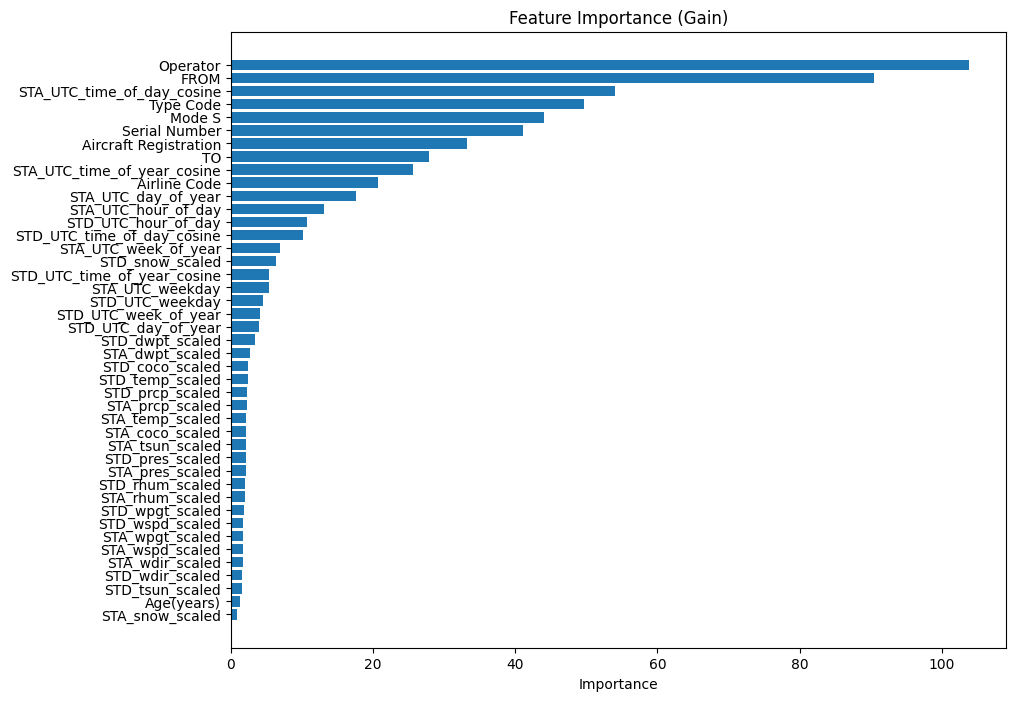

In [17]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming 'model' is trained using xgb.train()
# Extract feature importance based on 'gain'
importance_dict = model.get_score(importance_type='gain')

# Convert dictionary to sorted list
sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract names and importance values
feature_names, importance = zip(*sorted_features) if sorted_features else ([], [])

# Plot Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importance)
plt.xlabel('Importance')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a34848ba-0e8a-480c-b5ca-9121d5beac34' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Grid Search Archieve

In [11]:
import time
import pandas as pd # Ensuring pandas is imported
import numpy as np
import xgboost as xgb # Re-importing xgboost as well
from sklearn.model_selection import train_test_split, ParameterGrid

# Re-importing the dataset for reinitialization
df = pd.read_parquet('data.parquet')

# Reinitializing:
columns_to_drop = [col for col in df.columns if col.startswith('ATA') or col.startswith('ATD') or col == 'Arrival_Delayed']
df.drop(columns=columns_to_drop, inplace=True)

# Convert float64 to float32
float_cols = df.select_dtypes(include='float64').columns
df[float_cols] = df[float_cols].astype('float32')

# Convert int64 to int32
int_cols = df.select_dtypes(include='int64').columns
df[int_cols] = df[int_cols].astype('int32')

# Restart grid search setup
X = df.drop(columns=["Departure_Status"])
y = df["Departure_Status"].astype('category').cat.codes

#  Data splitting again
xTrain, xTemp, yTrain, yTemp = train_test_split(X, y, test_size=0.4, random_state=42)
xTest, xVal, yTest, yVal = train_test_split(xTemp, yTemp, test_size=0.5, random_state=42)

# Creating DMatrixes
dtrain = xgb.DMatrix(xTrain, label=yTrain, enable_categorical=True)
dval = xgb.DMatrix(xVal, label=yVal, enable_categorical=True)
dtest = xgb.DMatrix(xTest, label=yTest, enable_categorical=True)
start_time = time.time()
# Setting the grid search variables
params_grid = {
    'objective': ['multi:softmax'],
    'num_class': [3],
    'eval_metric': ['mlogloss'],
    'max_depth': [6, 8, 10],
    'eta': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'lambda': [1, 3, 5],
    'alpha': [0, 0.1, 0.5],
    'tree_method': ['gpu_hist'],
    'random_state': [42]
}

best_params = None
best_score = float('inf')
evals = [(dtrain, 'Train'), (dval, 'Validation')]
num_round = 300
params = next(iter(ParameterGrid(params_grid)))  # Take first param combination
model = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10, verbose_eval=False)

print("Time per model:", time.time() - start_time, "seconds")


/root/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:11:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Time per model: 101.6463577747345 seconds


### result of grid search
```
{'alpha': 0,
 'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0,
 'lambda': 3,
 'max_depth': 10,
 'num_class': 3,
 'objective': 'multi:softmax',
 'random_state': 42,
 'subsample': 1.0,
 'tree_method': 'gpu_hist'}
 ```